In [1]:
import os
import glob
import operator as op

import numpy             as np
import matplotlib.pyplot as plt

from CCutils import lmap
from CCutils import npmap
from CCfun   import in_range
from CCfun   import compute_baseline_float
from CCfun   import datetime_from_spectrum

from CCplot  import plot1d
from CCplot  import plot_line
from CCplot  import auto_plot_style
from CCplot  import figure_sizes
from CCplot  import subplots

from CCfit   import shifted_gauss
from CCfit   import shifted_expo
from CCfit   import fit

from CCio    import load_ccd_file

In [2]:
maindir = "/home/gonzalo/data/CC/caf_orientation_dependence//"

auto_plot_style({"lines.markersize" : 10})

In [3]:
def orderer(filename):
    basename = filename.split("/")[-1]
    tokens   = basename.split("_")
    index    = 0
    for token in tokens:
        if token[0].isdigit():
            index = 100 * index + int(token)
    return index

def find_max(x, y):
    m  = in_range(x, 600, 900)
    return y[m].max()

def sum_(x, y):
    m  = in_range(x, 600, 900)
    return y[m].sum()

def integrate(emwl, spectrum, rebin_by=1):
    x  = emwl
    y  = spectrum
    y -= compute_baseline_float(y)
    if rebin_by > 1:
        x = rebin(x, rebin_by, np.mean)
        y = rebin(y, rebin_by, np.sum )
    
    y  = y[x > 630]
    x  = x[x > 630]
    
    s  = find_max(x, y), 770,  30,  0
    f  = fit(shifted_gauss, x, y, s, fit_range = (600, 1150), maxfev=int(1e6))
    #plt.figure()
    #plt.plot(x, y, "k.")
    #plt.plot(x, f.fn(x), "b-")
    return f.values[0] * np.diff(x)[0]

def fit_selfbleach(x, y):
    s  = 1e9, -50, 5e9
    f  = fit(shifted_expo, x, y, s, maxfev=int(1e6))
    plt.scatter(x, y)
    plt.plot(x, f.fn(x), "y-")
    return f.values[0], -f.values[1], f.values[2]

# Different orientations of each crystal

In [4]:
def analyze(filenames, ncrystals):
    datas     =  lmap(load_ccd_file, filenames)
    em_wls    =  lmap(op.attrgetter("em_wl"), datas)
    times     = npmap(datetime_from_spectrum, datas)
    times     = npmap(op.attrgetter("seconds"), times - times[0]) * 1.0
    spectra   = [s.rate / s.power.mean for s in datas]
    peaks     = npmap(sum_, em_wls, spectra)
    integrals = npmap(integrate, em_wls, spectra)
    return integrals.reshape(ncrystals, len(integrals) // ncrystals)

filenames_front = sorted(glob.glob(os.path.join(maindir, "*front*signal*")), key=orderer)
filenames_left  = sorted(glob.glob(os.path.join(maindir,  "*left*signal*")), key=orderer)
filenames_top   = sorted(glob.glob(os.path.join(maindir,   "*top*signal*")), key=orderer)

integrals_front = analyze(filenames_front, 5)
integrals_left  = analyze(filenames_left , 5)
integrals_top   = analyze(filenames_top  , 5)

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


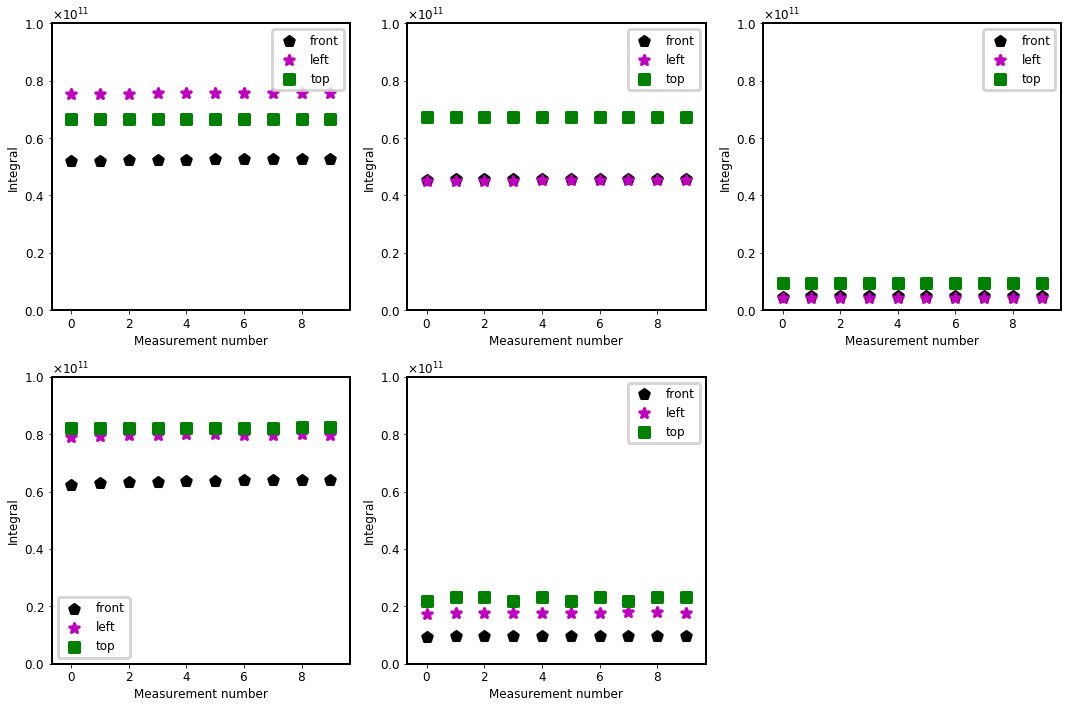

In [8]:
positions = integrals_front, integrals_left, integrals_top

plt.figure(figsize=(15, 10))
for marker, label, integrals in zip("p*s", "front left top".split(), positions):
    for i, crystal in enumerate(integrals, start=1):
        plt.subplot(2, 3, i)
        plt.scatter(np.arange(len(crystal)), crystal, marker=marker, label=label)

for i in range(1, 6):    
    plt.subplot(2, 3, i)
    plt.xlabel("Measurement number")
    plt.ylabel("Integral")
    plt.ylim(0, 1e11)
    plt.legend()
plt.tight_layout()